In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
df = pd.read_csv(r'/content/drive/MyDrive/sf-crime.zip (Unzipped Files)/train.csv.zip', parse_dates=['Dates'])


In [47]:
df.shape

(878049, 9)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       878049 non-null  datetime64[ns]
 1   Category    878049 non-null  object        
 2   Descript    878049 non-null  object        
 3   DayOfWeek   878049 non-null  object        
 4   PdDistrict  878049 non-null  object        
 5   Resolution  878049 non-null  object        
 6   Address     878049 non-null  object        
 7   X           878049 non-null  float64       
 8   Y           878049 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


In [49]:
print(df.Category.nunique())
df.Category.value_counts(normalize=True)[:10]

39


,proportion
Category,
LARCENY/THEFT,0.199192
OTHER OFFENSES,0.143707
NON-CRIMINAL,0.105124
ASSAULT,0.087553
DRUG/NARCOTIC,0.061467
VEHICLE THEFT,0.061251
VANDALISM,0.050937
WARRANTS,0.048077
BURGLARY,0.041860


In [50]:
usecols = ['Dates', 'X','Y', 'Category']
df.shape, df.drop_duplicates(subset=usecols).shape

((878049, 9), (812460, 9))

In [51]:
print(df.duplicated().sum())

df = df.drop_duplicates().reset_index(drop=True)

2323


In [52]:
df['X'].describe()


,X
count,875726.000000
mean,-122.422623
std,0.030363
min,-122.513642
25%,-122.432952
50%,-122.416446
75%,-122.406959
max,-120.500000


In [53]:
df['Y'].describe()


,Y
count,875726.000000
mean,37.771032
std,0.457497
min,37.707879
25%,37.752427
50%,37.775421
75%,37.784380
max,90.000000


In [55]:
df[df.Y > 38].shape


(67, 9)

In [56]:
df[df.Y > 38].duplicated(subset=['X', 'Y', 'Category'], keep=False).sum()


np.int64(61)

In [57]:
df = df[df.Y <= 38].reset_index(drop=True)

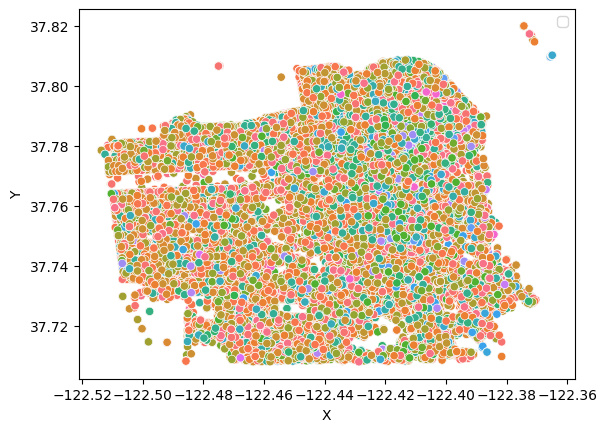

In [58]:
sns.scatterplot(
    data=df.drop_duplicates(subset=['X','Y', 'Category']),
    x='X',
    y='Y',
    hue='Category'
)
plt.legend(labels = []);

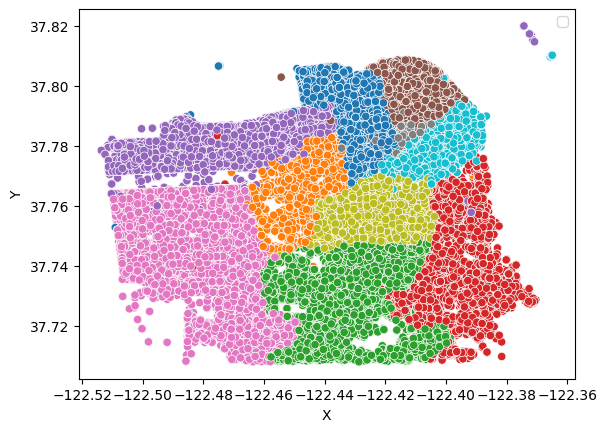

In [59]:
sns.scatterplot(
    data=df.drop_duplicates(subset=['X','Y', 'Category', 'PdDistrict']),
    x='X',
    y='Y',
    hue='PdDistrict'
)
plt.legend(labels = []);


In [60]:
# df['target']
df.Category.value_counts()


,count
Category,
LARCENY/THEFT,174305
OTHER OFFENSES,125943
NON-CRIMINAL,91911
ASSAULT,76811
DRUG/NARCOTIC,53919
VEHICLE THEFT,53697
VANDALISM,44580
WARRANTS,42137
BURGLARY,36599


In [61]:
df['year'] = df['Dates'].dt.year
df['month'] = df['Dates'].dt.month
df['day'] = df['Dates'].dt.day

df['dayofweek'] = df['Dates'].dt.dayofweek


In [62]:
usecols = [
    'PdDistrict', 'Address', 'X', 'Y',
    'year', 'month', 'day', 'dayofweek'
]


In [63]:
df.Descript.nunique(), df.PdDistrict.nunique(), df.Address.nunique()


(879, 10, 23191)

In [64]:
df[usecols].duplicated().sum(), df[usecols + ['Category']].duplicated().sum()

(np.int64(242639), np.int64(91705))

In [65]:
df = df.drop_duplicates(subset=usecols).reset_index(drop=True)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    df[usecols],
    df.Category,
    test_size=.3,
    random_state=2024,
    shuffle=True,
)

X_train.shape, X_test.shape

((443114, 8), (189906, 8))

In [67]:
cat_features = ['PdDistrict', 'Address', 'dayofweek']

In [68]:
cat_pipe = Pipeline([
    ('encoder', OrdinalEncoder(
        unknown_value=-1,
        handle_unknown='use_encoded_value'))
])

rest_pipe = Pipeline([
    ('scaler', StandardScaler())
])

In [69]:
prep_pipe = ColumnTransformer([
    ('cat_pipe', cat_pipe, cat_features),
    ('rest_pipe', rest_pipe, [x for x in X_train.columns if x not in cat_features])
])

In [70]:
prep_pipe.fit(X_train, y_train)

ColumnTransformer(transformers=[('cat_pipe',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['PdDistrict', 'Address', 'dayofweek']),
                                ('rest_pipe',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['X', 'Y', 'year', 'month', 'day'])])

In [71]:
prep_pipe.fit(X_train, y_train)

ColumnTransformer(transformers=[('cat_pipe',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['PdDistrict', 'Address', 'dayofweek']),
                                ('rest_pipe',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['X', 'Y', 'year', 'month', 'day'])])

In [72]:
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier


In [73]:
x = []
test_scores = []
train_scores = []
X_test_transformed = prep_pipe.transform(X_test)
X_train_transformed = prep_pipe.transform(X_train)

for n in range(1, 30):
    print(f'step {n}', end='\r')
    clf = RandomForestClassifier(n_estimators=n, n_jobs=-1, max_depth=3)
    clf.fit(X_train_transformed, y_train)

    test_scores.append(
    roc_auc_score(
        y_test,
        clf.predict_proba(X_test_transformed),
        multi_class='ovr'
    ))

    train_scores.append(
    roc_auc_score(
        y_train,
        clf.predict_proba(X_train_transformed),
        multi_class='ovr'
    ))

    x.append(n)

    if abs(test_scores[-1] - train_scores[-1]) > .2:
        print(f'n_estimators: {n}')
        print(f'scores train/test {train_scores[-1]:.2f}/{test_scores[-1]:2f}')
        break

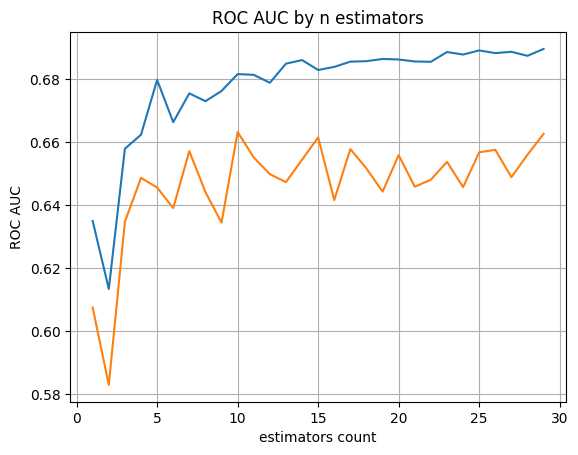

In [74]:
plt.plot(x, train_scores)
plt.plot(x, test_scores)
plt.grid()
plt.title('ROC AUC by n estimators')
plt.xlabel('estimators count')
plt.ylabel('ROC AUC');

In [75]:
n_estimator = [i for i,x in enumerate(test_scores) if x == max(test_scores)]
n_estimator

[9]

In [76]:
clf = RandomForestClassifier(n_estimators=n, n_jobs=-1, max_depth=3)
clf.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=3, n_estimators=29, n_jobs=-1)

In [77]:
test = pd.read_csv(r'/content/drive/MyDrive/sf-crime.zip (Unzipped Files)/test.csv.zip', parse_dates=['Dates'])

In [78]:
test['year'] = test.Dates.dt.year
test['month'] = test.Dates.dt.month
test['day'] = test.Dates.dt.day
test['dayofweek'] = test.Dates.dt.dayofweek

In [79]:
result = pd.DataFrame(
    clf.predict_proba(prep_pipe.transform(test[usecols])),
    columns = clf.classes_
)

In [80]:
result['Id'] = test['Id']

In [81]:
result.to_csv(r'submission.csv', index=False)